In [19]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data cleaning

In [25]:
df = pd.read_csv('../combined_hwz.csv', names=['Drop','ThreadName', 'ThreadLink', 'User','UserLink','Rank','Date','text']) 
df.head() #Filter by dates and then keep text?

df = df[["Date","text"]]

df["Year"] = df["Date"].str.split("-").str[2]

df["Month"] = df["Date"].str.split("-").str[1]

df_assigned = df
df_assigned = df_assigned.reset_index(drop=True)

In [27]:
df_assigned["text"]

0         Looking to replace 3x aircons for our HDB flat...
1         Something just occured to me, do you think tha...
2         A freehold semi-detached house at 61 Jalan Kel...
3         Need some advice here from the property gurus ...
4         Any grants taken will go back to the CPF accou...
                                ...                        
315552    call me a stereotype, if possible i will not l...
315553    Rental flat got many problem one. I will not s...
315554    the estate across the road to mine has rental....
315555    halfnode said:\nthe estate across the road to ...
315556    Looking to replace 3x aircons for our HDB flat...
Name: text, Length: 315557, dtype: object

In [43]:
# Remove non-English words
# Dictionary of English Contractions
# remove punc 
df_assigned['clean_text']  = df_assigned['text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: x.lower())
# tokenize
df_assigned['clean_text']  = [word_tokenize(row) for row in df_assigned['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https"]
stop_words.extend(new_stop_words)

# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https","us"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: remove_stopwords(x))

df_assigned['join_clean_text']  = df_assigned['clean_text'].apply(lambda x: " ".join(x))
# take out posts containing these amenities
df_assigned = df_assigned[df_assigned['join_clean_text'].str.contains("hawker|mrt|clinic|school|hospital|mall|market|express")]
df_assigned


,Date,text,Year,Month,clean_text,join_clean_text,real_Date
2,26-Nov-20,A freehold semi-detached house at 61 Jalan Kel...,20,Nov,"[freehold, semi, detached, house, 61, jalan, k...",freehold semi detached house 61 jalan kelawar ...,2020-11-26
59,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...",19,Jan,"[mine, 20, years, resale, flat, top, 1999, got...",mine 20 years resale flat top 1999 got bomb sh...,2019-01-25
60,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,19,Jan,"[kimurayuki, mine, 20, years, resale, flat, to...",kimurayuki mine 20 years resale flat top 1999 ...,2019-01-25
74,23-Nov-20,"A 4,822 sq ft unit at luxury condo, Nassim Par...",20,Nov,"[4, 822, sq, ft, unit, luxury, nassim, park, r...",4 822 sq ft unit luxury nassim park residences...,2020-11-23
90,22-Nov-20,vinz said:\r\nWrote to HDB in OCT 2020 to get ...,20,Nov,"[vinz, wrote, hdb, oct, 2020, get, confirmatio...",vinz wrote hdb oct 2020 get confirmation eligi...,2020-11-22
...,...,...,...,...,...,...,...
315397,30-Nov-20,A four-storey shophouse at 11 New Bridge Road ...,20,Nov,"[four, storey, shophouse, 11, new, bridge, roa...",four storey shophouse 11 new bridge road marke...,2020-11-30
315415,29-Nov-20,"The price of 1 bedder in D19 for example, pric...",20,Nov,"[price, 1, bedder, d19, example, price, around...",price 1 bedder d19 example price around 750 85...,2020-11-29
315451,25-Nov-20,angrymonster said:\n324k to 397k\n\nStack 123 ...,20,Nov,"[angrymonster, 324k, 397k, stack, 123, top, fl...",angrymonster 324k 397k stack 123 top floor sta...,2020-11-25
315455,25-Nov-20,Is it true that top floor units are taller in ...,20,Nov,"[true, top, floor, units, taller, height, floo...",true top floor units taller height floor plan ...,2020-11-25


In [45]:
# split before and after covid
df_assigned = df_assigned.dropna()

df_assigned["real_Date"] = pd.to_datetime(df["Date"], errors = 'coerce')
after_covid = df_assigned[df_assigned["real_Date"] >= '2020-04-07']

before_covid = df_assigned[df_assigned["real_Date"] < '2020-04-07']
before_covid = before_covid[before_covid["real_Date"] > '2017-01-01']

after_covid.to_csv("aftercovid.csv",index=False)

before_covid
before_covid.to_csv("beforecovid.csv",index=False)

after_covid = pd.read_csv("aftercovid.csv")
before_covid = pd.read_csv("beforecovid.csv")

### preparing overall EDA (freq and word cloud)

In [5]:
new_tokens = []
for i in df_assigned["clean_text"].tolist():
    new_tokens+= i
print(new_tokens[1:100])

['semi', 'detached', 'house', '61', 'jalan', 'kelawar', 'market', '7', '84', 'million', 'knight', 'frank', 'singapore', 'appointed', 'estate', 'sole', 'marketing', 'agent', 'sale', 'two', 'storey', 'house', 'sits', 'plot', '3', '100', 'sq', 'ft', 'nine', 'metre', 'frontage', 'jalan', 'kelawar', 'asking', 'price', 'translates', 'land', 'rate', '2', '500', 'psf', 'https', 'edgeprop', 'sg', 'property', 'ne', 'arezone', 'utm', 'medium', 'utm', 'campaign', 'forumposting', 'mine', '20', 'years', 'resale', 'flat', 'top', '1999', 'got', 'bomb', 'shelter', 'aircon', 'ledge', 'noise', 'external', 'traffic', 'supermarket', 'loading', 'bay', 'crazyclubx', 'last', 'time', 'rent', 'unfortunately', 'bought', 'punggol', 'house', 'thought', 'home', 'haiz', 'end', 'peace', 'knew', 'rather', 'rent', 'forever', 'least', 'change', 'buy', 'wait', '5', 'years', 'sell', 'move', 'slamming', 'doors', 'clearly', 'heard']


In [6]:
# loading in all the essentials for data manipulation
import pandas as pd
import numpy as np
#load in the NTLK stopwords to remove articles, preposition and other words that are not actionable
from nltk.corpus import stopwords
# This allows to create individual objects from a bog of words
from nltk.tokenize import word_tokenize
# Lemmatizer helps to reduce words to the base form
from nltk.stem import WordNetLemmatizer
# Ngrams allows to group words in common pairs or trigrams..etc
from nltk import ngrams
# We can use counter to count the objects 
from collections import Counter
# This is our visual library
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('omw-1.4')


lemmatizer = WordNetLemmatizer()
new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
#counts the words, pairs and trigrams
counted = Counter(new_tokens)
counted_2= Counter(ngrams(new_tokens,2))
counted_3= Counter(ngrams(new_tokens,3))
#creates 3 data frames and returns thems
word_freq = pd.DataFrame(counted.items(),columns=["word","frequency"]).sort_values(by="frequency",ascending=False)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)
# trigrams =pd.DataFrame(counted_3.items(),columns=[‘trigrams’,’frequency’]).sort_values(by=’frequency’,ascending=False)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<AxesSubplot:xlabel='frequency', ylabel='pairs'>

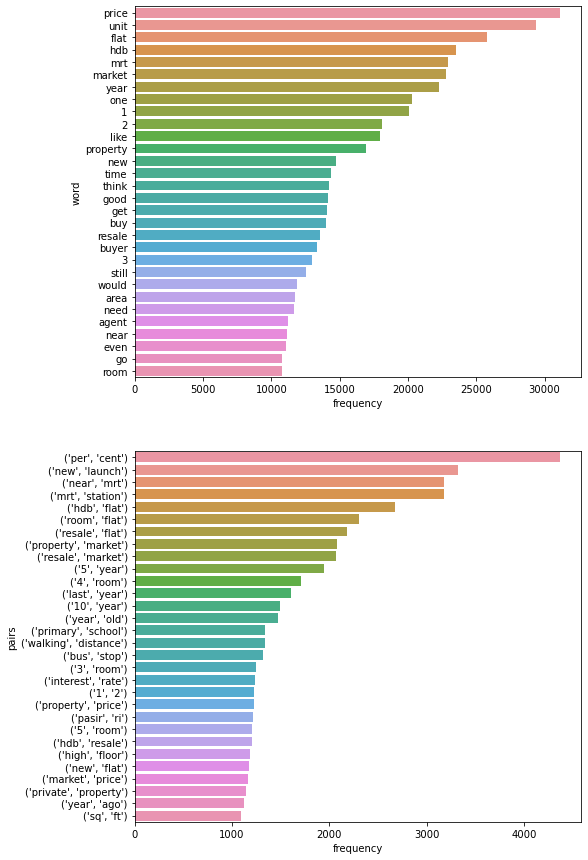

In [7]:
word_freq
fig, axes = plt.subplots(2,1,figsize=(8,15))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))

In [8]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
# description_str = ''
# for word_list in df_assigned['clean_text'].values:
#     description_str += ' '.join(row for row in word_list) + ' '

description_str = " ".join(new_tokens)


new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1,width=1200, height=800)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("wordcloud_hardwarezone.png")

### preparing before EDA (freq and word cloud)

In [9]:
before_covid["clean_text"][1]

"['kimurayuki', 'mine', '20', 'years', 'resale', 'flat', 'top', '1999', 'got', 'bomb', 'shelter', 'aircon', 'ledge', 'noise', 'external', 'traffic', 'supermarket', 'loading', 'bay', 'well', 'mine', '7', '8', 'years', 'old', 'resales', 'flat', 'yes', 'home', 'heard', 'traffic', 'besides', 'busy', 'road', 'traffic', 'noise', 'sleep', 'w', 'aircon', 'noise', 'neighbour', 'made', 'slammed', 'doors', 'sometime', '1', '2am', 'sometimes', 'things', 'dropped', '2', '3am', 'think', 'timing', 'quiet', 'time', 'normal', 'ppl', 'sleep', 'haiz', 'spore', 'shld', 'law', 'inconsiderate', 'neighbours']"

In [10]:
new_tokens = []
for i in before_covid["join_clean_text"].tolist():
    new_tokens+= i.split()
print(new_tokens[1:100])

['20', 'years', 'resale', 'flat', 'top', '1999', 'got', 'bomb', 'shelter', 'aircon', 'ledge', 'noise', 'external', 'traffic', 'supermarket', 'loading', 'bay', 'crazyclubx', 'last', 'time', 'rent', 'unfortunately', 'bought', 'punggol', 'house', 'thought', 'home', 'haiz', 'end', 'peace', 'knew', 'rather', 'rent', 'forever', 'least', 'change', 'buy', 'wait', '5', 'years', 'sell', 'move', 'slamming', 'doors', 'clearly', 'heard', 'hdb', 'stayed', 'hear', 'noise', 'slamming', 'doors', 'haiz', 'noisy', 'inconsiderate', 'upstairs', 'neighbours', 'r', 'pain', 'kimurayuki', 'mine', '20', 'years', 'resale', 'flat', 'top', '1999', 'got', 'bomb', 'shelter', 'aircon', 'ledge', 'noise', 'external', 'traffic', 'supermarket', 'loading', 'bay', 'well', 'mine', '7', '8', 'years', 'old', 'resales', 'flat', 'yes', 'home', 'heard', 'traffic', 'besides', 'busy', 'road', 'traffic', 'noise', 'sleep', 'w', 'aircon', 'noise']


In [11]:
# loading in all the essentials for data manipulation

lemmatizer = WordNetLemmatizer()
new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
#counts the words, pairs and trigrams
counted = Counter(new_tokens)
counted_2= Counter(ngrams(new_tokens,2))
counted_3= Counter(ngrams(new_tokens,3))
#creates 3 data frames and returns thems
word_freq = pd.DataFrame(counted.items(),columns=["word","frequency"]).sort_values(by="frequency",ascending=False)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)
# trigrams =pd.DataFrame(counted_3.items(),columns=[‘trigrams’,’frequency’]).sort_values(by=’frequency’,ascending=False)

<AxesSubplot:xlabel='frequency', ylabel='pairs'>

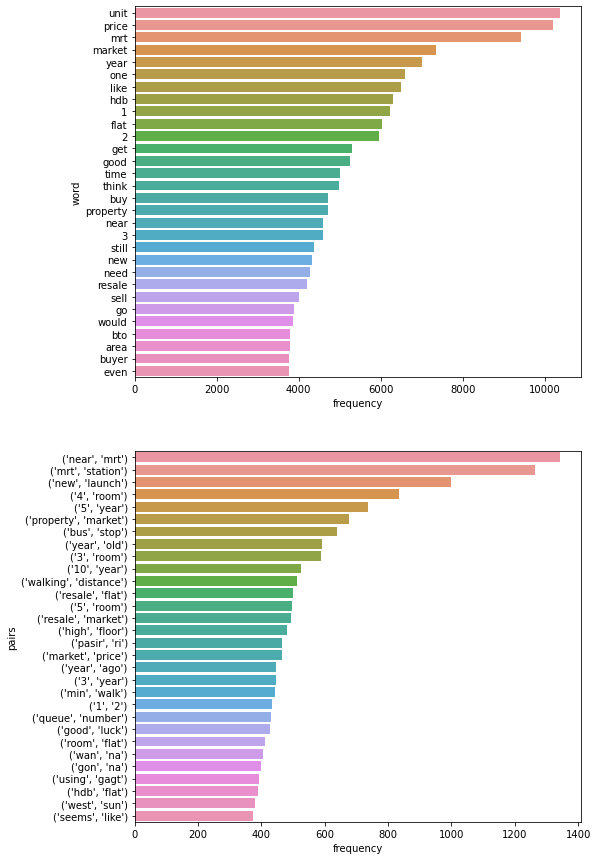

In [12]:
word_freq
fig, axes = plt.subplots(2,1,figsize=(8,15))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))

In [13]:
description_str = " ".join(new_tokens)


new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1,width=1200, height=800)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("wordcloud_hardwarezone_before_covid.png")

### preparing after EDA (freq and word cloud)

In [14]:
new_tokens = []
for i in after_covid["join_clean_text"].tolist():
    new_tokens+= i.split()
print(new_tokens[1:100])
# loading in all the essentials for data manipulation

lemmatizer = WordNetLemmatizer()
new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
#counts the words, pairs and trigrams
counted = Counter(new_tokens)
counted_2= Counter(ngrams(new_tokens,2))
counted_3= Counter(ngrams(new_tokens,3))
#creates 3 data frames and returns thems
word_freq = pd.DataFrame(counted.items(),columns=["word","frequency"]).sort_values(by="frequency",ascending=False)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)
# trigrams =pd.DataFrame(counted_3.items(),columns=[‘trigrams’,’frequency’]).sort_values(by=’frequency’,ascending=False)

['semi', 'detached', 'house', '61', 'jalan', 'kelawar', 'market', '7', '84', 'million', 'knight', 'frank', 'singapore', 'appointed', 'estate', 'sole', 'marketing', 'agent', 'sale', 'two', 'storey', 'house', 'sits', 'plot', '3', '100', 'sq', 'ft', 'nine', 'metre', 'frontage', 'jalan', 'kelawar', 'asking', 'price', 'translates', 'land', 'rate', '2', '500', 'psf', 'https', 'edgeprop', 'sg', 'property', 'ne', 'arezone', 'utm', 'medium', 'utm', 'campaign', 'forumposting', '4', '822', 'sq', 'ft', 'unit', 'luxury', 'nassim', 'park', 'residences', 'put', 'market', 'price', 'tag', 'upwards', '13', '98', 'million', '2', '899', 'psf', 'https', 'edgeprop', 'sg', 'property', 'ne', 'arezone', 'utm', 'medium', 'utm', 'campaign', 'forumposting', 'vinz', 'wrote', 'hdb', 'oct', '2020', 'get', 'confirmation', 'eligibility', 'apply', 'bto', 'current', 'resale', 'flat', 'without', 'grant', 'taking']


<AxesSubplot:xlabel='frequency', ylabel='pairs'>

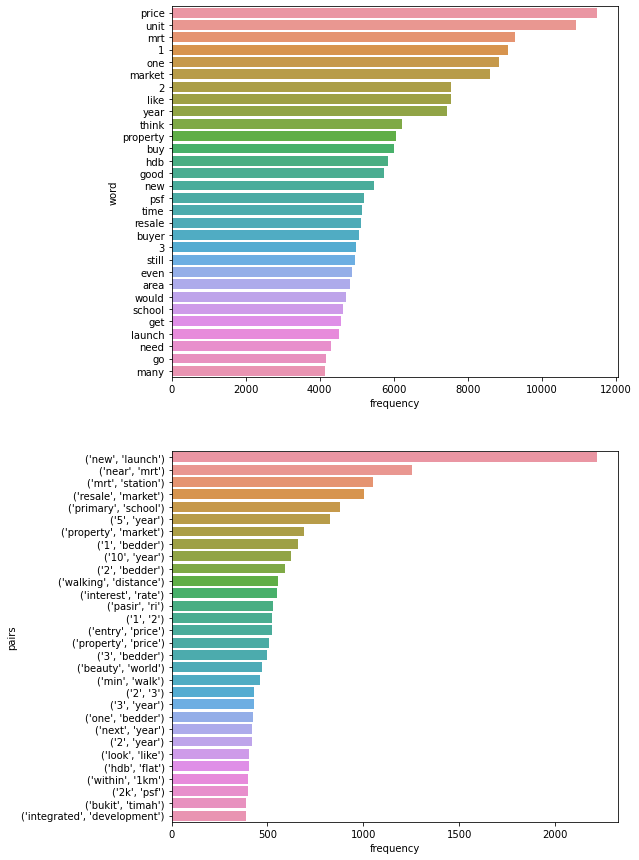

In [15]:
word_freq
fig, axes = plt.subplots(2,1,figsize=(8,15))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))

In [16]:
description_str = " ".join(new_tokens)


new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1,width=1200, height=800)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("wordcloud_hardwarezone_after_covid.png")